# Summary

In this Jupyter Notebook xarray and opendap are used to access [National Data Buoy Center](https://www.ndbc.noaa.gov/) data to compare waves on the east vs. west coast (Southern California) of the US during the recent El Nino-fueled winter of 2023/2024. I do this using the following metrics:
1. Significant Wave Height ($H_{1/3}$)
2. Dominant wave period ($\tau$)
3. Wave energy flux ($c_g\left<E\right>$)

### Import Modules

If using Google Colab run the next cell otherwise skip over to the next cell.

In [ ]:
!pip install xarray
!pip install netcdf4
!pip install cmocean
!pip install thredds_crawler

In [ ]:
from cmocean import cm
import datetime as dt
import pandas as pd
import xarray as xr
import numpy as np
from xml.dom import minidom
import urllib, requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from thredds_crawler.crawl import Crawl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 4.6 MB/s eta 0:00:00


## Buoy Locations

To compare East coast vs. Southern California:
## East Coast
1. North Carolina, Northern Outer Banks: NDBC 44095 Oregon Inlet
2. Rhode Island: NDBC 44097 Block Island
## Southern California
1. California, San Diego: NDBC 46258 Mission Bay West
2. Califirnoa, Los Angeles: NDBC 46221 Santa Monica Bay

In [ ]:
buoys = ['44095', '44097', '46258', '46221']
station_name = ['Oregon Inlet (NC)', 'Block Island (RI)',
                'Mission Bay West (CA)', 'Santa Monica Bay (CA)']

### Opendap URLs

The NDBC [opendap catalog](https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/catalog.html) has opendap links for buoys by station.  We can look at the last 45 days of standard meteorology (stdmet) hourly data using the '{station}h9999.nc' files.

In [ ]:
opendap_base = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/'
urls = [f"{opendap_base}{n}/{n}h9999.nc" for n in buoys]
urls

['https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44095/44095h9999.nc',
 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44097/44097h9999.nc',
 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46258/46258h9999.nc',
 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/46221/46221h9999.nc']

## Xarray

In [ ]:
var_names = [f"ds_{n}" for n in buoys]
datasets = {}
nbuoys = len(buoys)
for n in range(nbuoys):
  datasets[var_names[n]] = xr.open_dataset(urls[n])

In [ ]:
datasets

{'ds_44095': <xarray.Dataset>
 Dimensions:                  (latitude: 1, longitude: 1, time: 3118)
 Coordinates:
   * latitude                 (latitude) float32 35.75
   * longitude                (longitude) float32 -75.33
   * time                     (time) datetime64[ns] 2023-12-06T00:26:00 ... 20...
 Data variables: (12/13)
     air_pressure             (time, latitude, longitude) float32 ...
     air_temperature          (time, latitude, longitude) float32 ...
     average_wpd              (time, latitude, longitude) timedelta64[ns] ...
     dewpt_temperature        (time, latitude, longitude) float32 ...
     dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
     gust                     (time, latitude, longitude) float32 ...
     ...                       ...
     sea_surface_temperature  (time, latitude, longitude) float32 ...
     visibility               (time, latitude, longitude) float32 ...
     water_level              (time, latitude, longitude

In [ ]:
%whos

Variable              Type        Data/Info
-------------------------------------------
Crawl                 type        <class 'thredds_crawler.crawl.Crawl'>
buoys                 list        n=4
cm                    module      <module 'cmocean.cm' from<...>-packages/cmocean/cm.py'>
datasets              dict        n=4
ds                    Dataset     <xarray.Dataset>\nDimensi<...>nlimited_Dimension:  time
dt                    module      <module 'datetime' from '<...>/python3.10/datetime.py'>
make_axes_locatable   function    <function make_axes_locatable at 0x7b308eba68c0>
minidom               module      <module 'xml.dom.minidom'<...>3.10/xml/dom/minidom.py'>
n                     int         3
nbuoys                int         4
np                    module      <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
opendap_base          str         https://dods.ndbc.noaa.go<...>hredds/dodsC/data/stdmet/
pd                    module      <module 'pandas' from '/u<...>ages/

In [ ]:
# datasets["ds_44095"]
datasets[f"ds_{buoys[0]}"]

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 3118)
Coordinates:
  * latitude                 (latitude) float32 35.75
  * longitude                (longitude) float32 -75.33
  * time                     (time) datetime64[ns] 2023-12-06T00:26:00 ... 20...
Data variables: (12/13)
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    dewpt_temperature        (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    gust                     (time, latitude, longitude) float32 ...
    ...                       ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    visibility               (time, latitude, longitude) float32 ...
    water_level              (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
Attributes:
    institution:                     NOAA National Data Buoy Center and Parti...
    url:                             http://dods.ndbc.noaa.gov
    quality:                         Automated QC checks with daily manual QC
    conventions:                     COARDS
    station:                         44095
    comment:                         Oregon Inlet, NC (192)
    location:                        35.750 N 75.330 W 
    DODS_EXTRA.Unlimited_Dimension:  time

### Significant Wave Heights

Text(0.5, 1.0, 'Significant Wave Height')

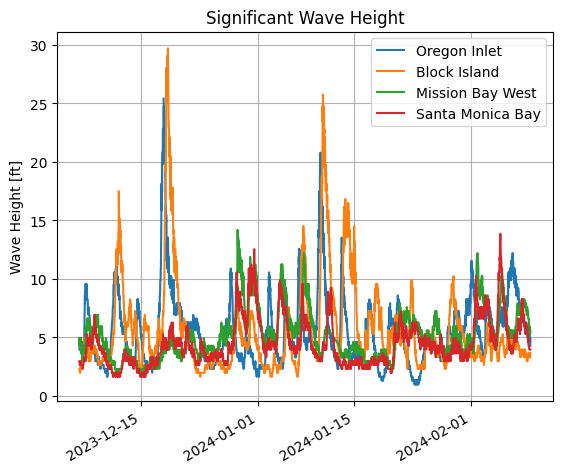

In [ ]:
for n in range(nbuoys):
  wave_height = datasets[f"ds_{buoys[n]}"].wave_height*3.3 # ft
  wave_height.squeeze().plot()

plt.grid(True)
plt.legend(station_name)
plt.xlabel('')
plt.ylabel('Wave Height [ft]')
plt.title('Significant Wave Height')

### Dominant Wave Period

Text(0.5, 1.0, 'Dominant Wave Period')

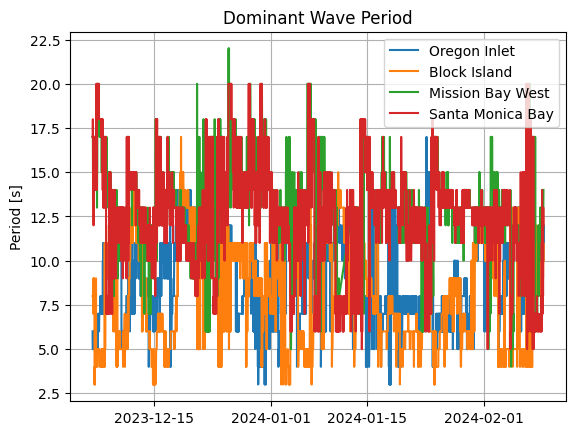

In [ ]:
for n in range(nbuoys):
  time = datasets[f"ds_{buoys[n]}"].time
  dominant_wpd = np.array(
      datasets[f"ds_{buoys[n]}"].dominant_wpd.squeeze()
      ).astype(float)/1e9
  indx = np.where(dominant_wpd < 0)[0]
  dominant_wpd[indx] = np.nan
  plt.plot(time, dominant_wpd)

plt.grid(True)
plt.legend(station_name)
plt.xlabel('')
plt.ylabel('Period [s]')
plt.title('Dominant Wave Period')

### Wave Energy Flux

Defined as group velocity, $c_g$, times the total energy averaged over a period/wavelength, $\left<E\right>$:   

$\displaystyle c_g\left<E\right> = \frac{\rho g}{32\pi}\tau H^2_{1/3}$

It is assumed that the waves are deep-water surface gravity waves (SGWs), which have a group velocity that depends on period, which is also conserved for SGWs.  

Text(0.5, 1.0, 'Wave Energy Flux')

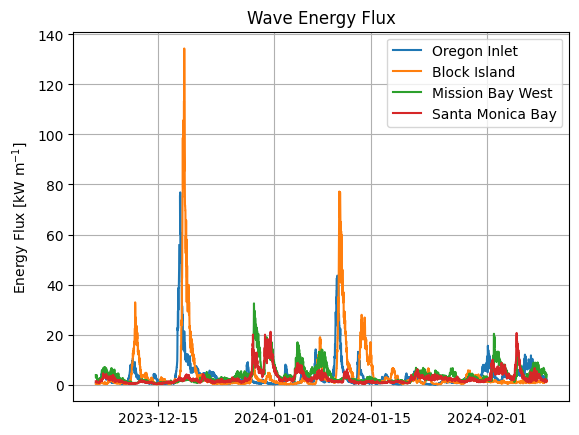

In [ ]:
rho = 1e3
g = 9.81
for n in range(nbuoys):
  time = datasets[f"ds_{buoys[n]}"].time
  wave_height = np.array(
      datasets[f"ds_{buoys[n]}"].wave_height.squeeze()
      ).astype(float) # m
  dominant_wpd = np.array(
      datasets[f"ds_{buoys[n]}"].dominant_wpd.squeeze()
      ).astype(float)/1e9
  indx = np.where(dominant_wpd < 0)[0]
  dominant_wpd[indx] = np.nan
  Eflux = rho*g/(32*np.pi)*dominant_wpd*(wave_height)**2
  plt.plot(time, Eflux/1e3)

plt.grid(True)
plt.legend(station_name)
plt.xlabel('')
plt.ylabel('Energy Flux [kW m$^{-1}$]')
plt.title('Wave Energy Flux')

Combine all three into one figure

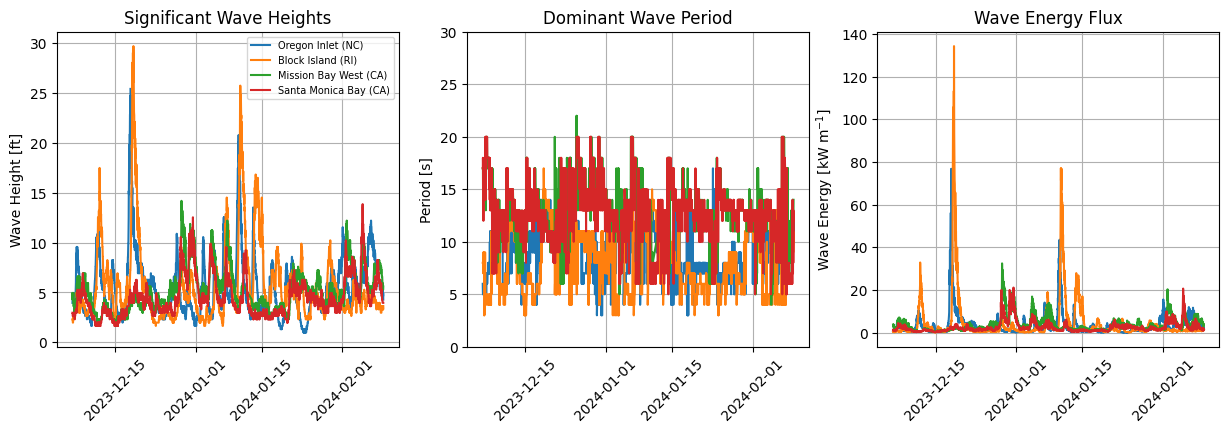

In [ ]:
plt.rcParams['figure.figsize'] = (15, 9)

for n in range(nbuoys):
  time = datasets[f"ds_{buoys[n]}"].time
  wave_height = np.array(
      datasets[f"ds_{buoys[n]}"].wave_height.squeeze()
      ).astype(float) # m
  dominant_wpd = np.array(
      datasets[f"ds_{buoys[n]}"].dominant_wpd.squeeze()
      ).astype(float)/1e9
  indx = np.where(dominant_wpd < 0)[0]
  dominant_wpd[indx] = np.nan
  Eflux = rho*g/(32*np.pi)*dominant_wpd*(wave_height)**2
  plt.subplot(231)
  plt.plot(time, wave_height*3.3)

  plt.subplot(232)
  plt.plot(time, dominant_wpd)

  plt.subplot(233)
  plt.plot(time, Eflux/1e3)

plt.subplot(231)
plt.legend(station_name, fontsize=7)
plt.xticks(rotation=45)
plt.ylabel('Wave Height [ft]')
plt.title('Significant Wave Heights')
plt.grid(True)

plt.subplot(232)
plt.ylim(0, 30)
plt.xticks(rotation=45)
plt.ylabel('Period [s]')
plt.title('Dominant Wave Period')
plt.grid(True)

plt.subplot(233)
plt.xticks(rotation=45)
plt.ylabel('Wave Energy [kW m$^{-1}$]')
plt.title('Wave Energy Flux')
plt.grid(True)